# Initialize

In [1]:
import os
init=False

# Imports

In [2]:
if not init:
    os.chdir('..')
    init=True
from pythonfigures.datapartition import DataPartitioner
from pythonfigures.neuraldatabase import Query
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import LeaveOneOut as LOO
from scipy.linalg import subspace_angles, orth

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors

# Query Fixation, Cue, and Movement period data, show they're all orthogonalizable

In [3]:
dp = DataPartitioner(session='Zara70',
                    areas=['M1'],
                    aligns=['fixation','cue onset','go cue onset','movement onset','hold'],
                    contexts=['active','passive'],
                    groupings=['context','alignment','grip','object','turntable','time'])

print( dp.get('groupings') )

[[], ['context'], ['alignment'], ['context', 'alignment'], ['grip'], ['context', 'grip'], ['alignment', 'grip'], ['context', 'alignment', 'grip'], ['object'], ['context', 'object'], ['alignment', 'object'], ['context', 'alignment', 'object'], ['grip', 'object'], ['context', 'grip', 'object'], ['alignment', 'grip', 'object'], ['context', 'alignment', 'grip', 'object'], ['turntable'], ['context', 'turntable'], ['alignment', 'turntable'], ['context', 'alignment', 'turntable'], ['grip', 'turntable'], ['context', 'grip', 'turntable'], ['alignment', 'grip', 'turntable'], ['context', 'alignment', 'grip', 'turntable'], ['object', 'turntable'], ['context', 'object', 'turntable'], ['alignment', 'object', 'turntable'], ['context', 'alignment', 'object', 'turntable'], ['grip', 'object', 'turntable'], ['context', 'grip', 'object', 'turntable'], ['alignment', 'grip', 'object', 'turntable'], ['context', 'alignment', 'grip', 'object', 'turntable'], ['time'], ['context', 'time'], ['alignment', 'time'],

In [4]:
# query the whole damn thing
df = dp.readQuery(0)

# convert from turntable x object ID vs. just the turntable ID
df['turntable'] = df['turntable'] // 10

print(df)

              n0        n1        n2   n3   n4        n5   n6        n7   n8  \
0       0.000000  0.206359  0.121723  0.0  0.0  0.000000  0.0  0.000898  0.0   
1       0.000000  0.204399  0.112033  0.0  0.0  0.000000  0.0  0.000437  0.0   
2       0.000000  0.203698  0.112068  0.0  0.0  0.000000  0.0  0.000205  0.0   
3       0.000000  0.204748  0.121851  0.0  0.0  0.000000  0.0  0.000092  0.0   
4       0.000000  0.207212  0.140386  0.0  0.0  0.000000  0.0  0.000040  0.0   
...          ...       ...       ...  ...  ...       ...  ...       ...  ...   
189595  0.196748  0.080032  0.344713  0.0  0.0  0.618005  0.0  0.362447  0.0   
189596  0.249929  0.101741  0.329224  0.0  0.0  0.725235  0.0  0.392635  0.0   
189597  0.305183  0.124266  0.311604  0.0  0.0  0.817700  0.0  0.408658  0.0   
189598  0.358102  0.145828  0.292481  0.0  0.0  0.885804  0.0  0.408658  0.0   
189599  0.403745  0.164420  0.273623  0.0  0.0  0.921954  0.0  0.392635  0.0   

         n9  ...  n180  n181  n182  tri

## Analysis Notes:
* look for the subspace that preferentially expresses fixation-period data and delete it
* why not just do dPCA? because dPCA does not admit mutually orthogonal subspaces!
* instead, you'll want to do hypothesis-driven dimensionality reduction
* you may need to use pymanopt to this end
* and sweep through dimensionality assignments!
* but that's a complicated analysis for another day...

## Focus on this for now:
1. Extract fixation-period baseline effects and determine their subspace
2. Extract (sustained) visual-period activity, determine its subspace
3. Extract movement-period activity, determine ITS subspace
4. Justification? Orthogonalization is computationally straightforward (you get to claim 'this is how the brain extracts this info'), data partitioning is not (you don't get to easily claim 'this is how the brain is doing things')
5. Do a battery of subspace-matching analyses
    1. Discovery of 1-to-1 matched patterns (to prove the need for orthogonalization) (needs pymanopt)
    2. Discovery of subspace distance (principal angles, alignment index)
    3. Decoding analysis applied to the raw data (self- and cross-decoding)

In [5]:
# get baseline effects (i.e., before even fixation)
df_fixation = df[(df['alignment']=='fixation') & (df['time']<0)].groupby(['context','turntable','object'])[dp.get('neuronColumnNames')].aggregate('mean')

# get vision-period effects (i.e., after cue onset)
df_vision = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object'])[dp.get('neuronColumnNames')].aggregate('mean')

# get movement-period effects (post-movement onset, skip the preparatory activity which is more grip-agnostic than the movement-period activity per se, at least in M1)
df_movement = df[(df['alignment']=='movement onset') & (df['time']>0)].groupby(['context','turntable','object'])[dp.get('neuronColumnNames')].aggregate('mean')

In [6]:
print(df_fixation)

                                          n0        n1        n2        n3  \
context turntable object                                                     
active  1         Ball 15 mm        0.014730  0.095651  0.205215  0.000000   
                  Ball 30 mm        0.019113  0.061286  0.276126  0.000000   
                  Bar 10 mm         0.013734  0.108235  0.231836  0.000000   
                  Cube 30 mm        0.100789  0.079746  0.263545  0.000000   
                  Cylinder H 30 mm  0.059278  0.080030  0.279731  0.000000   
                  Ring 50 mm        0.022924  0.087407  0.205359  0.000000   
        2         Ring 10 mm        0.038558  0.071081  0.244534  0.000000   
                  Ring 20 mm        0.045665  0.063701  0.145279  0.000000   
                  Ring 30 mm        0.049389  0.131229  0.248714  0.000000   
                  Ring 40 mm        0.010846  0.102119  0.199823  0.000000   
                  Ring 50 mm        0.051864  0.078376  0.211693

In [7]:
print(df_vision)

                                          n0        n1        n2  \
context turntable object                                           
active  1         Ball 15 mm        0.093740  0.077152  0.237086   
                  Ball 30 mm        0.053699  0.062667  0.262589   
                  Bar 10 mm         0.051004  0.096024  0.297341   
                  Cube 30 mm        0.093731  0.082139  0.286017   
                  Cylinder H 30 mm  0.091684  0.094706  0.324706   
                  Ring 50 mm        0.076402  0.064589  0.252698   
        2         Ring 10 mm        0.027455  0.072252  0.238897   
                  Ring 20 mm        0.049691  0.083891  0.316438   
                  Ring 30 mm        0.065038  0.064904  0.309588   
                  Ring 40 mm        0.134986  0.074054  0.314298   
                  Ring 50 mm        0.048510  0.099285  0.310210   
                  Ring 60 mm        0.081827  0.098240  0.378443   
        3         Cube 15 mm        0.126438  0.

In [8]:
print(df_movement)

                                          n0        n1        n2        n3  \
context turntable object                                                     
active  1         Ball 15 mm        0.218341  0.304865  0.403322  0.000000   
                  Ball 30 mm        0.326627  0.285469  0.363939  0.000000   
                  Bar 10 mm         0.118841  0.218802  0.259371  0.000000   
                  Cube 30 mm        0.275577  0.328473  0.361758  0.000000   
                  Cylinder H 30 mm  0.169334  0.207834  0.204201  0.000000   
                  Ring 50 mm        0.219137  0.227595  0.307876  0.000000   
        2         Ring 10 mm        0.437568  0.503677  0.336328  0.000081   
                  Ring 20 mm        0.202001  0.381399  0.263201  0.000000   
                  Ring 30 mm        0.151948  0.221831  0.256459  0.000000   
                  Ring 40 mm        0.188453  0.219796  0.269129  0.000260   
                  Ring 50 mm        0.214885  0.180683  0.276913

In [9]:
# convert to numpy
np_fixation = df_fixation.to_numpy()

np_vision = df_vision.to_numpy()

np_movement = dict()
np_movement['active'] = df_movement.loc['active'].to_numpy()
np_movement['passive'] = df_movement.loc['passive'].to_numpy()

In [10]:
# PCA
# note: 'mle' uses Minka's mle method
# here's the review that justifies it: https://www.mdpi.com/2227-7390/9/22/2840
# (but this tends to just extract *all* the dimensions...)
# but when there are more features than observations, we just use 'None' with the 'arpack' solver (get rid of the last component, which explains a singular data dimension)
pca_fixation = PCA(n_components=2).fit(np_fixation)

pca_vision = PCA(n_components=2).fit(np_vision)

pca_movement = dict()
pca_movement['active'] = PCA(n_components=2).fit(np_movement['active'])
pca_movement['passive'] = PCA(n_components=2).fit(np_movement['passive'])

In [11]:
# plot the top 2 components of each
x_fixation = pca_fixation.transform(np_fixation)

x_vision = pca_vision.transform(np_vision)

x_movement_on_viz = dict()
x_movement_on_viz['active'] = pca_vision.transform(np_movement['active']) # pca_movement['active'].transform(np_movement['active'])
x_movement_on_viz['passive'] = pca_vision.transform(np_movement['passive']) # pca_movement['passive'].transform(np_movement['passive'])

x_movement = dict()
x_movement['active'] = pca_movement['active'].transform(np_movement['active'])
x_movement['passive'] = pca_movement['passive'].transform(np_movement['passive'])

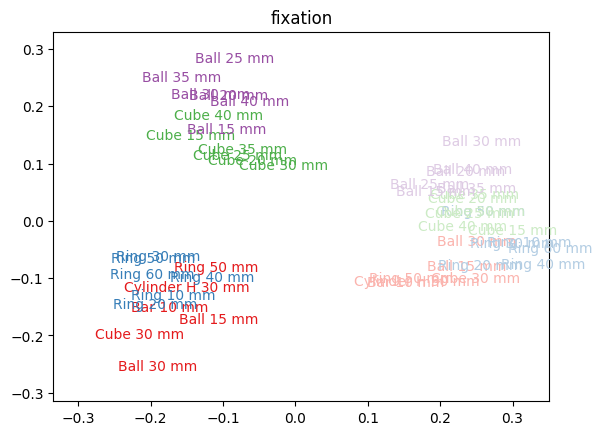

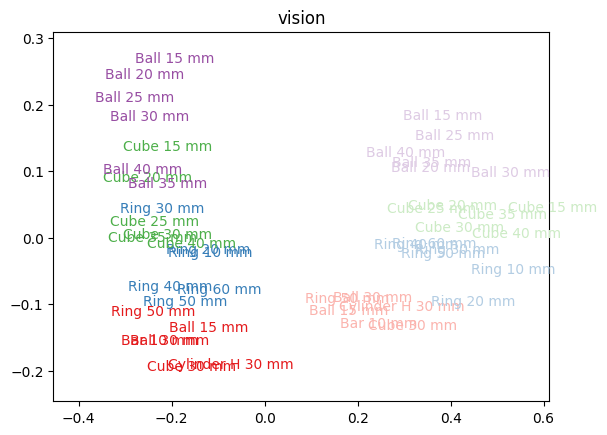

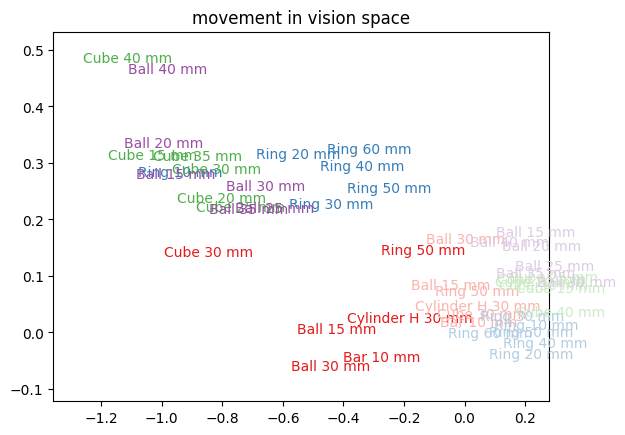

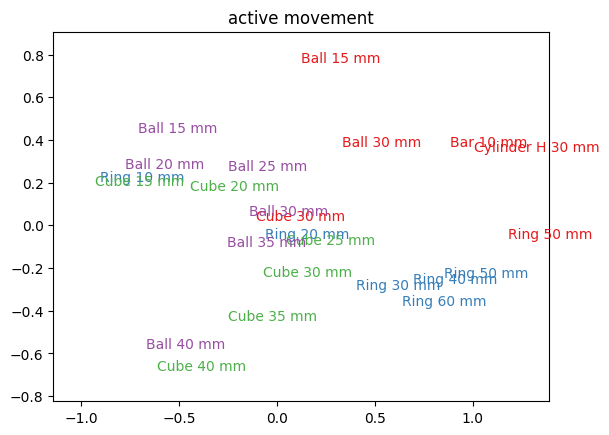

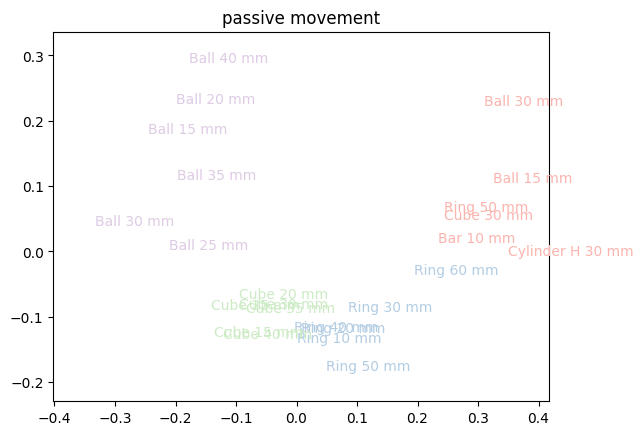

In [12]:
# plot the first 2 PCs

# fixation:
index_levels      = df_fixation.index.to_list()
unique_turntables = df_fixation.index.unique(1).to_list()

marker_color_indices = np.array([unique_turntables.index(x[1]) for x in index_levels])

context_names = df_fixation.index.unique(0).to_list()
marker_colormap_indices = np.array([context_names.index(x[0]) for x in index_levels])

cmaps = [cm.Set1,cm.Pastel1]

marker_x_positions = x_fixation[:,0]
marker_y_positions = x_fixation[:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
for contextind in range(len(context_names)):
    mx = marker_x_positions[marker_colormap_indices==contextind]
    my = marker_y_positions[marker_colormap_indices==contextind]
    mc = marker_color_indices[marker_colormap_indices==contextind]
    objnames = [x[2] for x in index_levels if x[0]==context_names[contextind]]
    
    for objind in range(len(objnames)):
        plt.text(x=mx[objind],
                 y=my[objind],
                 s=objnames[objind],
                 color=cmaps[contextind].colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("fixation")
plt.show()


# vision:
index_levels      = df_vision.index.to_list()
unique_turntables = df_vision.index.unique(1).to_list()

marker_color_indices = np.array([unique_turntables.index(x[1]) for x in index_levels])

context_names = df_vision.index.unique(0).to_list()
marker_colormap_indices = np.array([context_names.index(x[0]) for x in index_levels])

cmaps = [cm.Set1,cm.Pastel1]

marker_x_positions = x_vision[:,0]
marker_y_positions = x_vision[:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
for contextind in range(len(context_names)):
    mx = marker_x_positions[marker_colormap_indices==contextind]
    my = marker_y_positions[marker_colormap_indices==contextind]
    mc = marker_color_indices[marker_colormap_indices==contextind]
    objnames = [x[2] for x in index_levels if x[0]==context_names[contextind]]
    
    for objind in range(len(objnames)):
        plt.text(x=mx[objind],
                 y=my[objind],
                 s=objnames[objind],
                 color=cmaps[contextind].colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("vision")
plt.show()


# active movement on viz:
index_levels      = df_movement.loc['active'].index.to_list()
unique_turntables = df_movement.loc['active'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Set1

marker_x_positions = x_movement_on_viz['active'][:,0]
marker_y_positions = x_movement_on_viz['active'][:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """


# passive movement on viz:
index_levels      = df_movement.loc['passive'].index.to_list()
unique_turntables = df_movement.loc['passive'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Pastel1

marker_x_positions = x_movement_on_viz['passive'][:,0]
marker_y_positions = x_movement_on_viz['passive'][:,1]

xl_old = xl
xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

xl[0] = min(xl_old[0],xl[0])
xl[1] = max(xl_old[1],xl[1])

yl_old = yl
yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

yl[0] = min(yl_old[0],yl[0])
yl[1] = max(yl_old[1],yl[1])

mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("movement in vision space")
plt.show()


# active movement:
index_levels      = df_movement.loc['active'].index.to_list()
unique_turntables = df_movement.loc['active'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Set1

marker_x_positions = x_movement['active'][:,0]
marker_y_positions = x_movement['active'][:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

plt.figure()
mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("active movement")
plt.show()

# passive movement:
index_levels      = df_movement.loc['passive'].index.to_list()
unique_turntables = df_movement.loc['passive'].index.unique(0).to_list()

marker_color_indices = np.array([unique_turntables.index(x[0]) for x in index_levels])

cmap = cm.Pastel1

marker_x_positions = x_movement['passive'][:,0]
marker_y_positions = x_movement['passive'][:,1]

xl = [min(marker_x_positions),max(marker_x_positions)]
delx = xl[1]-xl[0]
xl[0] = xl[0]-0.1*delx
xl[1] = xl[1]+0.1*delx

yl = [min(marker_y_positions),max(marker_y_positions)]
dely = yl[1]-yl[0]
yl[0] = yl[0]-0.1*dely
yl[1] = yl[1]+0.1*dely

mx = marker_x_positions
my = marker_y_positions
mc = marker_color_indices
objnames = [x[1] for x in index_levels]

for objind in range(len(objnames)):
    plt.text(x=mx[objind],
             y=my[objind],
             s=objnames[objind],
             color=cmap.colors[mc[objind]])
    
    """
    plt.scatter(x=marker_x_positions[marker_colormap_indices==contextind],
               y=marker_y_positions[marker_colormap_indices==contextind],
               c=marker_color_indices[marker_colormap_indices==contextind],
               cmap = cmaps[contextind],
               vmin=0,
               vmax=9)
    """
plt.xlim(xl)
plt.ylim(yl)
plt.title("passive movement")
plt.show()

# block-identifying signals

In [13]:
# now do some classification to further prove your point
# first round: block decoding using the baseline activity
cv = LOO()

# fixation decoding of context x turntable (i.e., block)
df_fixation_trials = df[(df['alignment']=='fixation') & (df['time']<0)].groupby(['context','turntable','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
np_fixation_trials = df_fixation_trials.to_numpy()
# print(np_fixation_trials)
# print(np_fixation_trials.shape)
# print(len(dp.get('neuronColumnNames')))
# print(df_fixation_trials)

# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
labels = df_fixation_trials.index
labels = np.array( [f'{x[0]}{x[1]}' for x in labels] )
# print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_fixation_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_fixation_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_fixation_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")


correct classification rate = 0.6054852320675106
chance classification rate = 0.1268498942917548


In [14]:
# now, cross-classify
df_vision_trials = df[(df['alignment']=='cue onset') & (df['time']>0)].groupby(['context','turntable','object','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
np_vision_trials = df_vision_trials.to_numpy()
df_movement_trials = df[(df['alignment']=='movement onset') & (df['time']>0)].groupby(['context','turntable','object','grip','trial'])[dp.get('neuronColumnNames')].aggregate('mean')
np_movement_trials = df_movement_trials.to_numpy()

vislabels = df_vision_trials.index
vislabels = np.array( [f'{x[0]}{x[1]}' for x in vislabels] )

movlabels = df_movement_trials.index
movlabels = np.array( [f'{x[0]}{x[1]}' for x in movlabels] )

cmdl = LDA()
cmdl.fit(X=np_fixation_trials,
         y=labels)
yvis    = vislabels
yvishat = cmdl.predict(np_vision_trials)
print(f"correct vision cross-classification rate = {np.mean(yvishat==yvis)}")
print(f"chance classification rate = {max(cmdl.priors_)}")

ymov    = movlabels
ymovhat = cmdl.predict(np_movement_trials)
print(f"correct movement cross-classification rate = {np.mean(ymovhat==ymov)}")
print(f"chance classification rate = {max(cmdl.priors_)}")

correct vision cross-classification rate = 0.4409282700421941
chance classification rate = 0.12658227848101267
correct movement cross-classification rate = 0.16033755274261605
chance classification rate = 0.12658227848101267


# object-identifying signals

In [15]:
cv = LOO()

# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
labels = df_vision_trials.index
labels = np.array( [f'{x[2]}' for x in labels] )
#print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_vision_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_vision_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_vision_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")

correct classification rate = 0.10759493670886076
chance classification rate = 0.08456659619450316


In [16]:
# cross-classification
# (why is this crappier than I remember?)
# (answer: because it was only ever good when TESTING on the visual period!)
# (and frankly, during the movement period there was ALWAYS an interruption in good cross-classification performance. See the last Figure of: https://docs.google.com/presentation/d/1IvC2_D7bf76Ke4kYz79Q2XSELMNnFdhV/edit?usp=share_link&ouid=102831550401914517112&rtpof=true&sd=true)

# although c.f. Figure S2 of: https://docs.google.com/document/d/1H2v6pDNbmDsa1RKbVlUbwz7dvx_HH4wT/edit?usp=share_link&ouid=102831550401914517112&rtpof=true&sd=true
# it seems as though I really SHOULD be doing a lot better with my cross-classification here!
# AIP self-classification during illumination is somewhere in the 40-50% range, which I'm successfully replicating
# But AIP cross-classification during the late movement epoch holding steady at 40% should be what I see. Not this piddly 14% nonsense!

# [ ] is the issue as simple as needing to restrict myself to the VGG task?
# [ ] or needing to perform PCA preprocessing / apply a shrinkage parameter to stabilize the classifier? (it's the one thing I am NOT replicating from my MATLAB pipeline)

# np_movement_trials = df_movement_trials.to_numpy()
movlabels = df_movement_trials.index
movlabels = np.array( [f'{x[2]}' for x in movlabels] )

cmdl = LDA()
cmdl.fit(X=np_vision_trials,
         y=labels)

ymov    = movlabels
ymovhat = cmdl.predict(np_movement_trials)
print(f"correct movement cross-classification rate = {np.mean(ymovhat==ymov)}")
print(f"chance classification rate = {max(cmdl.priors_)}")

correct movement cross-classification rate = 0.0759493670886076
chance classification rate = 0.08438818565400844


# Grip decoding

In [17]:
# active
cv = LOO()

# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
np_active_movement_trials = df_movement_trials.loc['active'].to_numpy()
labels = df_movement_trials.loc['active'].index
labels = np.array( [f'{x[2]}' for x in labels] ) # we get rid of context by pulling from .loc['active'], thus we query [2] instead of [3]
#print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_active_movement_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_active_movement_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_active_movement_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")

correct classification rate = 0.5338983050847458
chance classification rate = 0.1694915254237288


In [18]:
# passive (note: no cross-grip decoding is possible!)
cv = LOO()

# if you just take the contexts [0] in the absence of precise turntable or block information [1], you can classify with accuracy of 90%!
np_passive_movement_trials = df_movement_trials.loc['passive'].to_numpy()
labels = df_movement_trials.loc['passive'].index
labels = np.array( [f'{x[2]}' for x in labels] ) # we get rid of context by pulling from .loc['active'], thus we query [2] instead of [3]
#print(labels)

correct_count = 0
total_count   = 0
chance        = []
for train_,test_ in cv.split(np_passive_movement_trials,labels):
    cmdl = LDA()
    cmdl.fit(X=np_passive_movement_trials[train_,:],
             y=labels[train_])
    
    y    = labels[test_]
    yhat = cmdl.predict(np_passive_movement_trials[test_,:])
    
    if y==yhat:
        correct_count+=1
        
    total_count+=1
    
    chance += [max(cmdl.priors_)]
    
print(f"correct classification rate = {correct_count / total_count}")
print(f"chance classification rate = {np.mean(chance)}")

correct classification rate = 0.08823529411764706
chance classification rate = 0.12605042016806725


In [19]:
np.mean([1,2,3])

2.0

In [20]:
index_levels

[(1, 'Ball 15 mm'),
 (1, 'Ball 30 mm'),
 (1, 'Bar 10 mm'),
 (1, 'Cube 30 mm'),
 (1, 'Cylinder H 30 mm'),
 (1, 'Ring 50 mm'),
 (2, 'Ring 10 mm'),
 (2, 'Ring 20 mm'),
 (2, 'Ring 30 mm'),
 (2, 'Ring 40 mm'),
 (2, 'Ring 50 mm'),
 (2, 'Ring 60 mm'),
 (3, 'Cube 15 mm'),
 (3, 'Cube 20 mm'),
 (3, 'Cube 25 mm'),
 (3, 'Cube 30 mm'),
 (3, 'Cube 35 mm'),
 (3, 'Cube 40 mm'),
 (4, 'Ball 15 mm'),
 (4, 'Ball 20 mm'),
 (4, 'Ball 25 mm'),
 (4, 'Ball 30 mm'),
 (4, 'Ball 35 mm'),
 (4, 'Ball 40 mm')]